**CHAPTER 3: Data quality Challenges**

# Notebook initialization

In [9]:
!wget https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/Titanic%20disaster/train.csv

--2024-11-05 09:19:29--  https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/Titanic%20disaster/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  58.89K  --.-KB/s    in 0.009s  

2024-11-05 09:19:29 (6.28 MB/s) - ‘train.csv.1’ saved [60302/60302]



In [10]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [11]:
import pandas as pd
df_original = None
df_original = pd.read_csv("/content/train.csv")
df_original.shape

(891, 12)

In [12]:
df_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Missing Values

In [ ]:
def display_missing_values(df):
  # Calculate the percentage of missing values in each column
  missing_percentage = df.isnull().sum() / len(df) * 100

  print("% of Missing values:")
  print(missing_percentage.apply(lambda x: f"{x:.1f}"))
  print("Rows: {} | Columns: {}".format(df.shape[0], df.shape[1]))
display_missing_values(df_original)

% of Missing values:
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age            19.9
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Cabin          77.1
Embarked        0.2
dtype: object
Rows: 891 | Columns: 12


There are missing values on columns Age and Cabin.

## Deletion

In [ ]:
# create a df copy first
df = df_original.copy()

# Perform listwise deletion
titanic_clean = df.dropna()

# Check the number of rows after listwise deletion
print("Number of rows after listwise deletion:", len(titanic_clean))

Number of rows after listwise deletion: 183


This removes all rows that have any missing values. You'll likely see a significant reduction in the number of rows.
Next, let's demonstrate column-wise deletion. We'll remove columns that have more than 50% missing values:

In [ ]:
# Identify columns with more than 50% missing values
missing_percentage = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index

# Drop these columns
titanic_reduced = df.drop(columns=columns_to_drop)
print ("columns dropped:", columns_to_drop)

# Check the remaining columns
print("Columns after dropping those with >50% missing values:")
print(titanic_reduced.columns)

# Check missing values in the remaining columns
print("Missing values in remaining columns:")
print(titanic_reduced.isnull().sum())
print("Number of rows:", len(titanic_reduced))

columns dropped: Index(['Cabin'], dtype='object')
Columns after dropping those with >50% missing values:
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')
Missing values in remaining columns:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64
Number of rows: 891


This approach removes entire columns with a high percentage of missing values, rather than removing rows.

Finally, let's combine both approaches:

In [ ]:
# First drop columns with >50% missing values, then do listwise deletion
titanic_final = titanic_reduced.dropna()

# Check the final number of rows and columns
print("Final number of rows:", len(titanic_final))
print("Final number of columns:", len(titanic_final.columns))

titanic_final.shape

Final number of rows: 712
Final number of columns: 11


(712, 11)

In [ ]:
display_missing_values(titanic_final)

% of Missing values:
PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: object
Rows: 712 | Columns: 11


This combines column-wise and listwise deletion to create a dataset with no missing values.
Remember, while deletion can be an effective way to handle missing data, it can also lead to loss of potentially valuable information. The decision to use deletion should be based on the amount of missing data, the importance of the variables, and the size of your dataset.

## Imputation

### Simple imputation

In [ ]:
# create a df copy first
df = df_original.copy()

display_missing_values(df)

% of Missing values:
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age            19.9
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Cabin          77.1
Embarked        0.2
dtype: object
Rows: 891 | Columns: 12


In [ ]:
# Calculate the mean age
mean_age = df['Age'].mean()

# Impute missing values in 'Age' with the mean
df['Age'].fillna(mean_age, inplace=True)

# Verify the imputation
print("Missing values in Age after imputation:", df['Age'].isnull().sum())

Missing values in Age after imputation: 0


This calculates the mean age of passengers and uses it to fill in missing age values.

Finally, let's use mode imputation for the 'Embarked' column:

In [ ]:
# Find the mode of 'Embarked'
mode_embarked = df['Embarked'].mode()[0]

# Impute missing values in 'Embarked' with the mode
df['Embarked'].fillna(mode_embarked, inplace=True)

# Verify the imputation
print("Missing values in Embarked after imputation:", df['Embarked'].isnull().sum())

Missing values in Embarked after imputation: 0


This finds the most common embarkation point and uses it to fill in any missing values in the 'Embarked' column.
After running these operations, you'll have handled missing values in the 'Age' and 'Embarked' columns of the Titanic dataset. Remember, the choice of imputation method should be based on the nature of your data and the requirements of your analysis.

### Forward and backward filling

In [ ]:
# create a df copy first
df = df_original.copy()

# Display original dataset with missing values in 'Age'
print("Original 'Age' column with missing values:\n", df['Age'])

# Forward fill (propagate the last valid observation forward)
df['age_ffill'] = df['Age'].fillna(method='ffill')
print("\n'Age' column after forward filling:\n", df['age_ffill'])

# Backward fill (propagate the next valid observation backward)
df['age_bfill'] = df['Age'].fillna(method='bfill')
print("\n'Age' column after backward filling:\n", df['age_bfill'])

Original 'Age' column with missing values:
 0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

'Age' column after forward filling:
 0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    19.0
889    26.0
890    32.0
Name: age_ffill, Length: 891, dtype: float64

'Age' column after backward filling:
 0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    26.0
889    26.0
890    32.0
Name: age_bfill, Length: 891, dtype: float64


<ipython-input-14-b3cd9e7a1e2a>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['age_ffill'] = df['Age'].fillna(method='ffill')
<ipython-input-14-b3cd9e7a1e2a>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['age_bfill'] = df['Age'].fillna(method='bfill')


### K-nearest neighbor

In [ ]:
from sklearn.impute import KNNImputer

# create a df copy first
df = df_original.copy()

# Create a KNNImputer instance with n_neighbors set to 3
imputer = KNNImputer(n_neighbors=3)

# Impute missing values in the 'Age' column
df['Age'] = imputer.fit_transform(df[['Age']])

display_missing_values(df)

% of Missing values:
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Cabin          77.1
Embarked        0.2
dtype: object
Rows: 891 | Columns: 12


### Interpolation

In [ ]:
df = df_original.copy()
df['Age'].interpolate(method='linear', inplace=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.5,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Prediction

let's prepare the data for prediction:

In [ ]:
# create a df copy first
df = df_original.copy()

# Select features to use for prediction
features = ['Pclass', 'SibSp', 'Parch', 'Fare']

# Create X (features) and y (target)
X = df[features]
y = df['Age']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split data into rows with known age and rows with missing age
X_known = X_imputed[y.notnull()]
y_known = y[y.notnull()]
X_missing = X_imputed[y.isnull()]

Next, we'll train a linear regression model on the known data:

In [ ]:
# Train the model
model = LinearRegression()
model.fit(X_known, y_known)

LinearRegression()

In [ ]:
# Predict missing ages
predicted_ages = model.predict(X_missing)

# Prediction can provides negative values, in this case we decide to replace by 0
predicted_ages = [age if age >= 0 else 0 for age in predicted_ages]

# Fill in the missing ages in the original dataset
df.loc[y.isnull(), 'Age'] = predicted_ages

print("Missing values in Age after imputation:", df['Age'].isnull().sum())

Missing values in Age after imputation: 0


This approach uses other features (Pclass, SibSp, Parch, and Fare) to predict missing Age values.

 We can create a scatter plot with known ages represented by blue circles and imputed ages represented by red crosses. We'll use the 'Fare' feature for the x-axis to create a 2D scatter plot.

(-5.0, 537.94566)

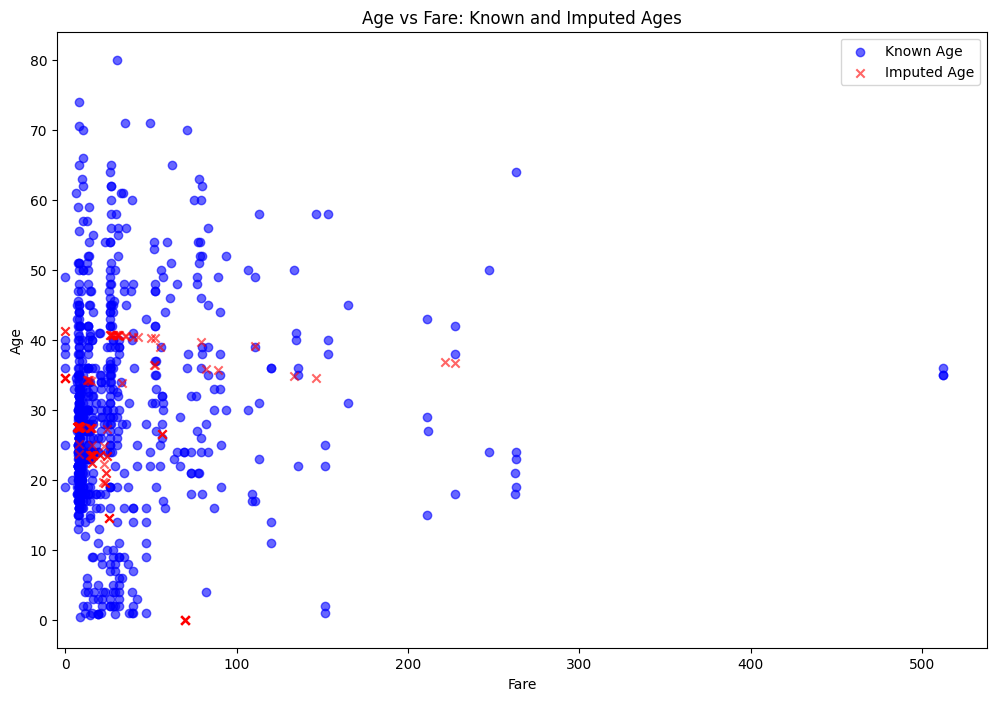

In [ ]:
missing_age_mask = df_original['Age'].isnull()
# Create the scatter plot
plt.figure(figsize=(12, 8))

# Plot known ages
plt.scatter(df.loc[~missing_age_mask, 'Fare'],
            df.loc[~missing_age_mask, 'Age'],
            color='blue', marker='o', label='Known Age', alpha=0.6)

# Plot imputed ages
plt.scatter(df.loc[missing_age_mask, 'Fare'],
            df.loc[missing_age_mask, 'Age'],
            color='red', marker='x', label='Imputed Age', alpha=0.6)

plt.title('Age vs Fare: Known and Imputed Ages')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.legend()

# Add a bit of jitter to x-axis for better visibility
plt.xlim(left=-5)

# Outliers

In [14]:
# Using the red wine dataset instead ?
#!wget https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/Wine%20quality/winequality-red.csv
#df_original = pd.read_csv("/content/winequality-red.csv", delimiter=";")

In [15]:
# create a df copy first
df = df_original.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
col_observation = 'Age'
distrib = df[col_observation].dropna()

## Outlier detection

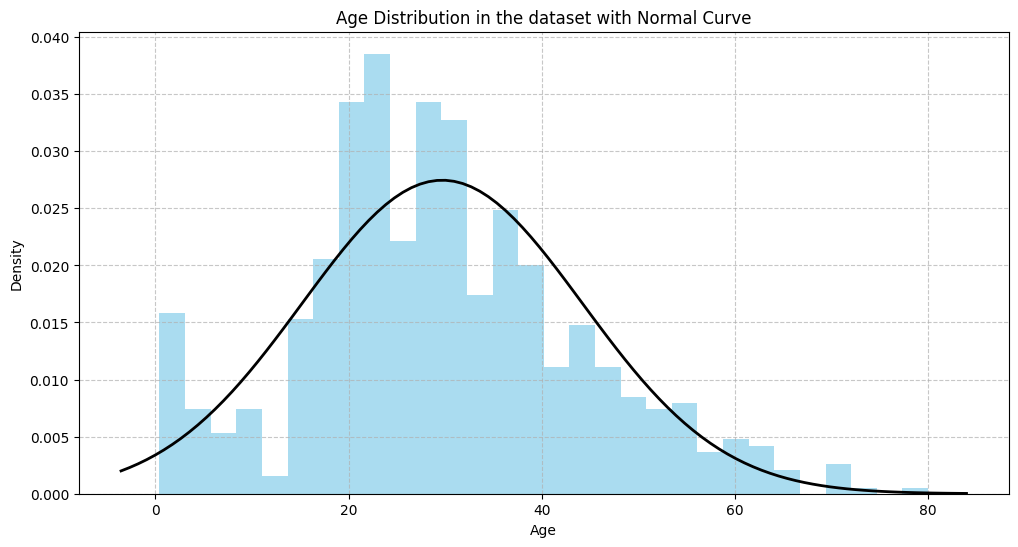

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create the histogram
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(distrib, bins=30, density=True, alpha=0.7, color='skyblue')

# Calculate the mean and standard deviation of the ages
mu, std = distrib.mean(), distrib.std()

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Customize the plot
plt.title(col_observation + ' Distribution in the dataset with Normal Curve')
plt.xlabel(col_observation)
plt.ylabel('Density')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

* Visual Inspection: Look at the histogram with the overlaid normal curve. If the distribution is normal, it should closely follow the curve.
* Shapiro-Wilk Test: This test has the null hypothesis that the data is normally distributed.
  * If the p-value is greater than 0.05, we fail to reject the null hypothesis, suggesting the distribution might be normal.
  * If the p-value is less than 0.05, we reject the null hypothesis, suggesting the distribution is likely not normal.

In [19]:
from scipy import stats

def shapiro(dist):
  # Perform Shapiro-Wilk test for normality
  statistic, p_value = stats.shapiro(dist)
  print(f"Shapiro-Wilk test results:")
  print(f"Statistic: {statistic:.6f}")
  print(f"p-value: {p_value:.6f}")
  if p_value > 0.05:
      print("The " + col_observation + " distribution is likely normal (fail to reject H0)")
  else:
      print("The " + col_observation + " distribution is likely not normal (reject H0)")

shapiro(distrib)

Shapiro-Wilk test results:
Statistic: 0.981458
p-value: 0.000000
The Age distribution is likely not normal (reject H0)


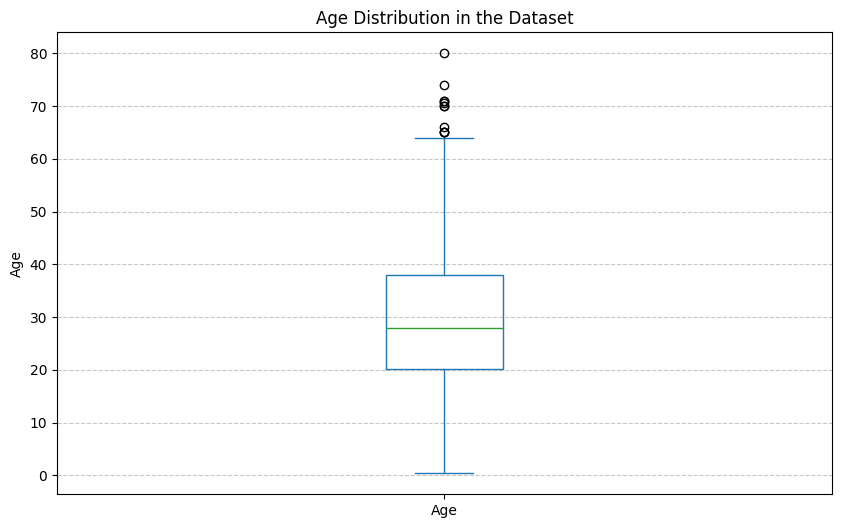

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the box plot
plt.figure(figsize=(10, 6))
distrib.plot(kind='box')

# Customize the plot
plt.title(col_observation + ' Distribution in the Dataset')
plt.ylabel(col_observation)

# Remove x-axis label as it's not meaningful in this context
plt.xlabel('')

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### 1. IQR Method

IQR Method: Calculates the interquartile range and identifies outliers based on the 1.5 * IQR rule. The function iqr_method() calculates the first quartile (Q1), third quartile (Q3), and the Interquartile Range (IQR). It then identifies outliers as any data points below Q1 - 1.5IQR or above Q3 + 1.5IQR.

In [ ]:
def iqr_method(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

iqr_outliers = iqr_method(distrib)
print("Number of outliers", len(iqr_outliers))
print(', '.join(map(str, iqr_outliers.values)))

Number of outliers 11
66.0, 65.0, 71.0, 70.5, 65.0, 65.0, 71.0, 80.0, 70.0, 70.0, 74.0


### 2. Z-Score Method

Computes Z-scores and flags data points with absolute Z-scores above 3 as outliers. The function zscore_method() calculates the Z-score for each data point (how many standard deviations away from the mean it is). It then flags any points with an absolute Z-score greater than the threshold (default 3) as outliers.

In [21]:
from scipy import stats
def zscore_method(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers = data[z_scores > threshold]
    return outliers

zscore_outliers = zscore_method(distrib)

In [22]:
print("Number of outliers", len(zscore_outliers))
print(', '.join(map(str, zscore_outliers.values)))

Number of outliers 2
80.0, 74.0


### 3. Mahalanobis Distance

Mahalanobis Distance: Uses scikit-learn's EllipticEnvelope, which is based on the Mahalanobis distance. It's set to consider 10% of the data as potential outliers. This method uses scikit-learn's EllipticEnvelope, which is based on the Mahalanobis distance. It reshapes the data for scikit-learn, fits the model, and identifies outliers. The 'contamination' parameter is set to 0.1, meaning it assumes 10% of the data are outliers.

In [23]:
def mahalanobis_method(data):
    # Reshape data for scikit-learn
    X = data.values.reshape(-1, 1)

    # Fit the Elliptic Envelope model
    outlier_detector = EllipticEnvelope(contamination=0.1, random_state=42)
    outlier_labels = outlier_detector.fit_predict(X)

    # Identify outliers
    outliers = data[outlier_labels == -1]
    return outliers

mahalanobis_outliers = mahalanobis_method(distrib)

In [24]:
print("Number of outliers", len(mahalanobis_outliers))
print(', '.join(map(str, mahalanobis_outliers.values)))

Number of outliers 75
54.0, 2.0, 58.0, 55.0, 2.0, 66.0, 65.0, 0.83, 59.0, 71.0, 70.5, 2.0, 54.0, 55.5, 1.0, 61.0, 1.0, 56.0, 1.0, 58.0, 2.0, 59.0, 54.0, 62.0, 58.0, 63.0, 65.0, 2.0, 0.92, 54.0, 61.0, 2.0, 60.0, 1.0, 1.0, 64.0, 65.0, 56.0, 0.75, 2.0, 63.0, 58.0, 55.0, 71.0, 54.0, 54.0, 2.0, 64.0, 62.0, 62.0, 53.0, 54.0, 60.0, 61.0, 57.0, 80.0, 2.0, 0.75, 56.0, 58.0, 70.0, 60.0, 60.0, 70.0, 0.67, 57.0, 54.0, 1.0, 0.42, 2.0, 1.0, 62.0, 0.83, 74.0, 56.0


### 4. Local Outlier Factor (LOF)

Local Outlier Factor (LOF): Implements the LOF algorithm using scikit-learn, considering 20 neighbors and flagging 10% of the data as potential outliers. This implements the LOF algorithm using scikit-learn. It considers the local density of data points, comparing each point to its neighbors. Points with a substantially lower density than their neighbors are flagged as outliers. The 'n_neighbors' parameter is set to 20, and 'contamination' is again set to 0.1.

In [25]:
def lof_method(data):
    # Reshape data for scikit-learn
    X = data.values.reshape(-1, 1)

    # Fit the LOF model
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outlier_labels = lof.fit_predict(X)

    # Identify outliers
    outliers = data[outlier_labels == -1]
    return outliers

lof_outliers = lof_method(distrib)
print("Number of outliers", len(lof_outliers))
print(', '.join(map(str, lof_outliers.values)))

Number of outliers 62
26.0, 20.0, 28.5, 26.0, 26.0, 23.0, 20.0, 26.0, 23.0, 37.0, 20.0, 20.0, 23.0, 37.0, 36.5, 26.0, 26.0, 20.5, 37.0, 37.0, 26.0, 23.5, 26.0, 26.0, 23.0, 20.0, 23.0, 23.0, 26.0, 20.0, 20.0, 23.0, 37.0, 26.0, 23.0, 37.0, 26.0, 26.0, 20.0, 26.0, 20.0, 23.0, 23.0, 20.0, 24.5, 20.0, 26.0, 20.0, 23.0, 23.0, 28.5, 23.0, 20.0, 30.5, 26.0, 30.5, 23.0, 23.0, 20.0, 26.0, 20.0, 26.0


Note that for simplicity, this example focuses on the 'Age' column of the Titanic dataset. For multivariate analysis (especially for Mahalanobis distance and LOF), we might want to include more features.
Also, the outlier detection thresholds (like the contamination factor in Mahalanobis and LOF methods) are set somewhat arbitrarily here.

## Outliers management

Function to showcase the outliers management results ...

In [26]:
def compare_dist(dataupdated, nbbins = 40):
  # Set up the plot
  plt.figure(figsize=(15, 6))
  # Define the bins
  bins = np.linspace(0, max(distrib.max(), dataupdated.max()), nbbins+1)  # x bins, ranging from 0 to the max
  bin_width = bins[1] - bins[0]
  # Calculate the histograms
  hist1, _ = np.histogram(distrib, bins=bins)
  hist2, _ = np.histogram(dataupdated, bins=bins)
  # Set up the bar positions
  bar_positions = np.arange(len(bins) - 1)
  bar_width = 0.35
  # Create the side-by-side bar chart
  plt.bar(bar_positions - bar_width/2, hist1, bar_width, alpha=0.8, color='black', label='Original dataset')
  plt.bar(bar_positions + bar_width/2, hist2, bar_width, alpha=0.8, color='grey', label='Dataset updated')
  # Customize the plot
  plt.title(col_observation + ' Distribution Comparison in dataset')
  plt.xlabel(col_observation)
  plt.ylabel('Frequency')
  plt.legend()
  # Set x-ticks to show age ranges
  plt.xticks(bar_positions, [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)])
  plt.xticks(rotation=45, ha='right')
  # Add grid for better readability
  plt.grid(True, axis='y', linestyle='--', alpha=0.7)
  # Adjust layout to prevent cutting off x-labels
  plt.tight_layout()
  # Show the plot
  plt.show()

### Removal

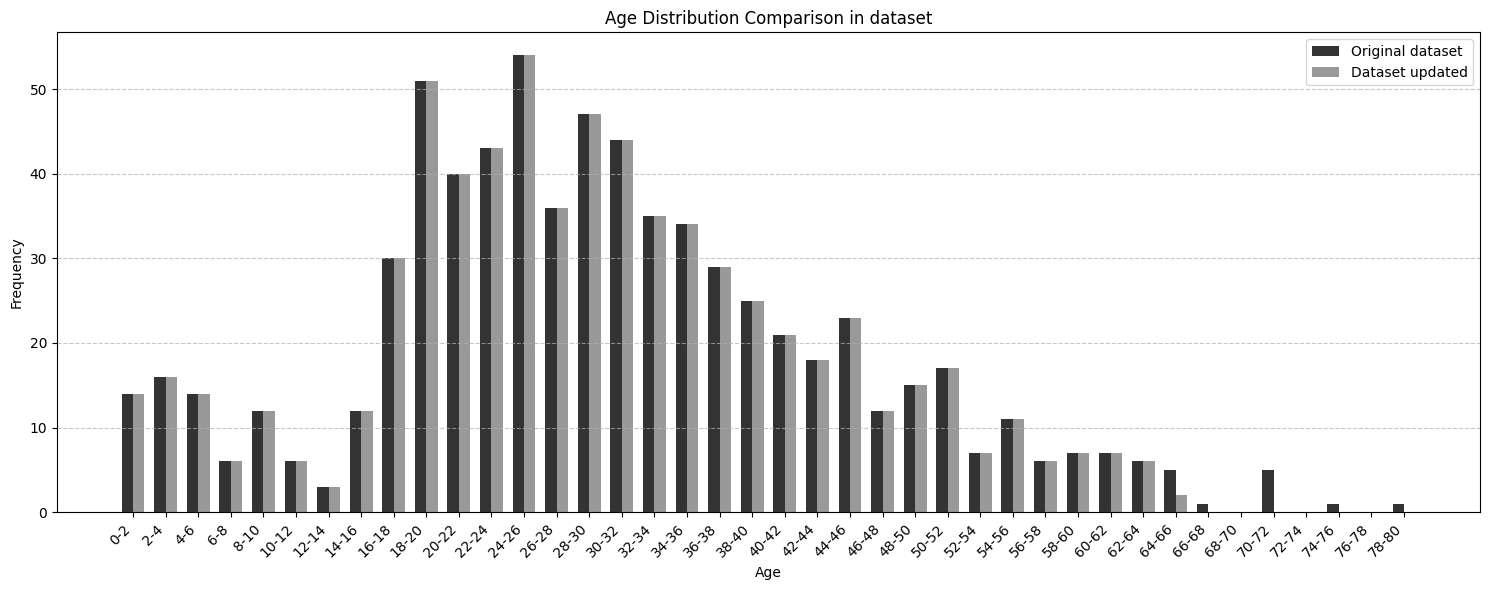

In [27]:
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]
dfo = remove_outliers(distrib.copy())
compare_dist(dfo)

### Capping

lower 1.0 - Uppper 65.87


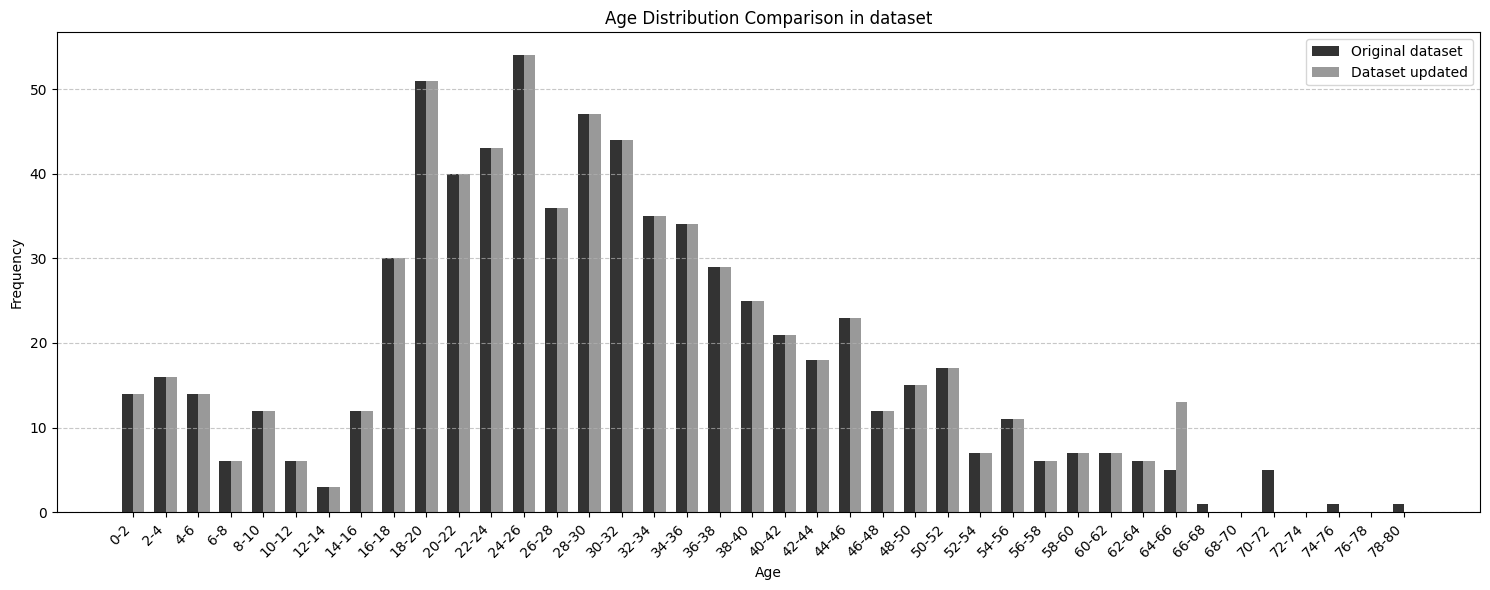

In [28]:
def cap_outliers(data, lower_percentile=0.01, upper_percentile=0.99):
    lower = data.quantile(lower_percentile)
    upper = data.quantile(upper_percentile)
    print (f"lower {lower} - Uppper {upper}")
    data = data.clip(lower, upper)
    return data
dfo = cap_outliers(distrib.copy())
compare_dist(dfo)

### Imputation

In [ ]:
distrib.median()

28.0

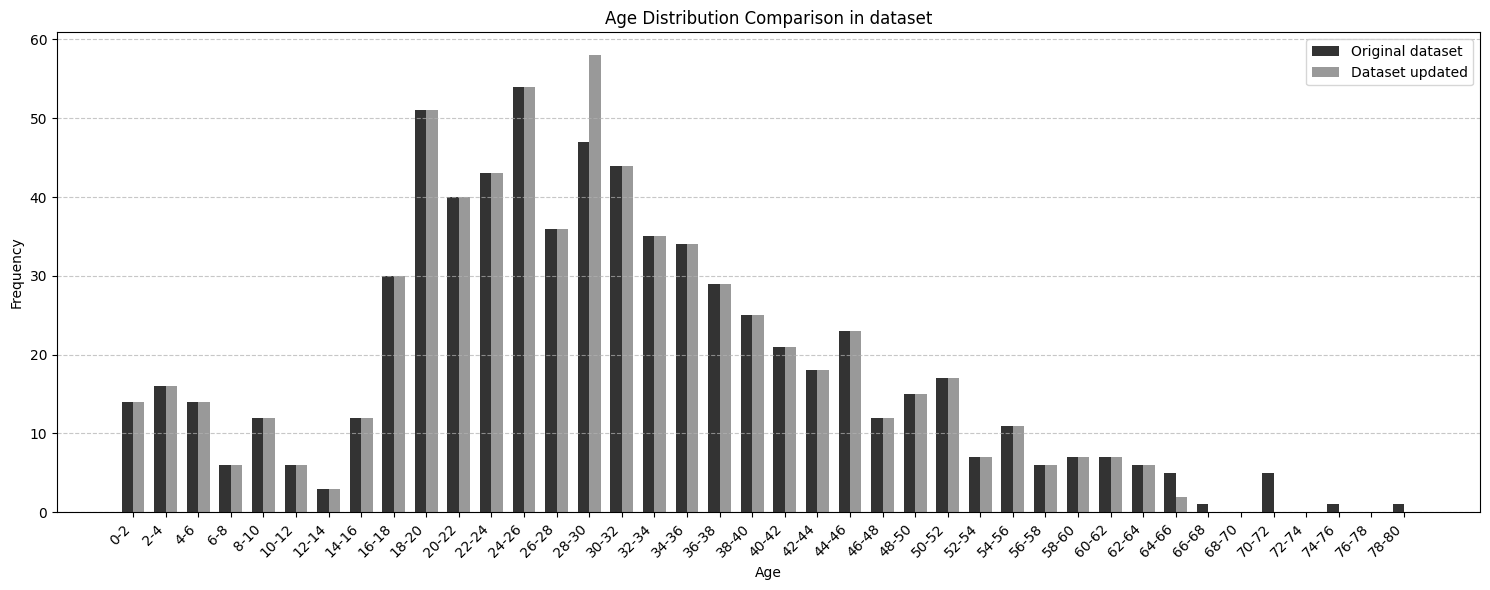

In [29]:
def impute_outliers(data, method='mean'):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    if method == 'mean':
        replacement_value = data.mean()
    elif method == 'median':
        replacement_value = data.median()
    elif method == 'mode':
        replacement_value = data.mode()[0]
    data[data < lower_bound] = replacement_value
    data[data > upper_bound] = replacement_value
    return data
dfo = impute_outliers(distrib.copy(), method='median')
compare_dist(dfo)

### Transformation

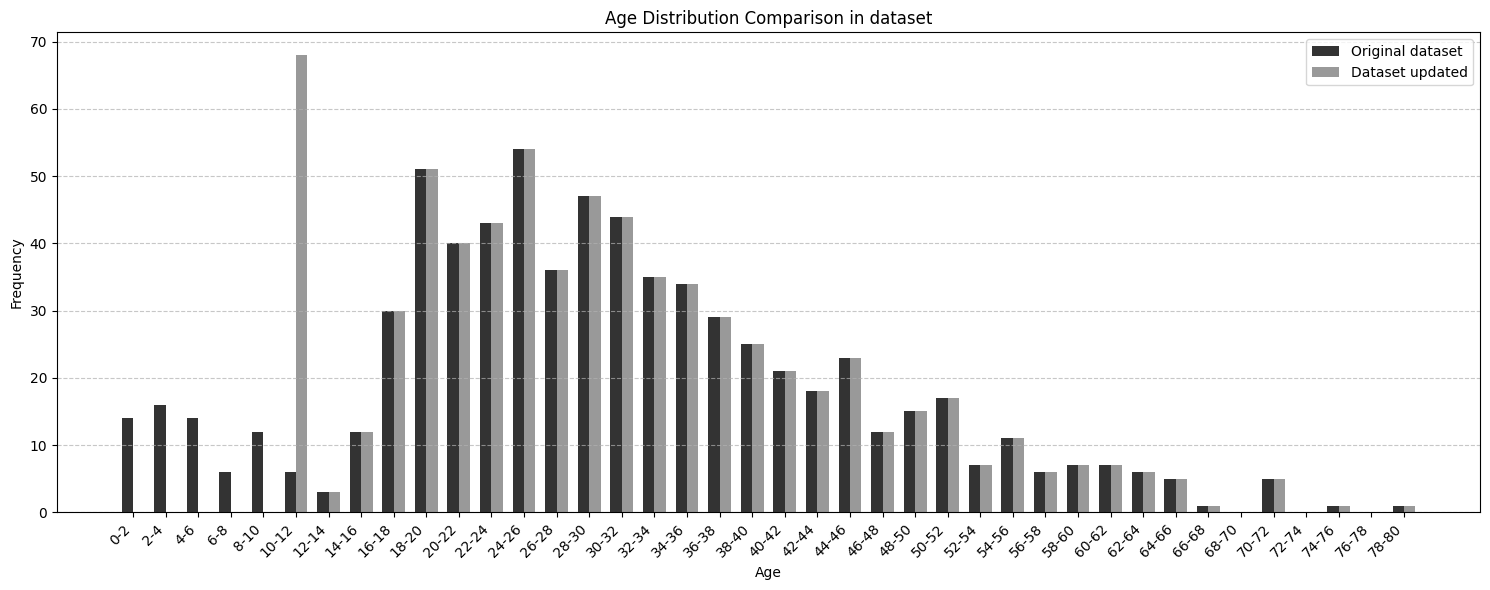

In [30]:
def mytransformation(dt):
  return dt if dt >10 else 10

def transform_data(data, method='log'):
  return distrib.apply(mytransformation)

dfo = transform_data(distrib.copy(), method='sqrt')
compare_dist(dfo)

The Box-Cox transformation, implemented in scipy through scipy.stats.boxcox, is a mathematical technique used to stabilize variance and make a dataset more normally distributed. It’s especially useful for data that is highly skewed, as it can reduce skewness and improve the suitability of the data for statistical models that assume normality (like linear regression).

Box-Cox transformation applied with lambda = 0.7628


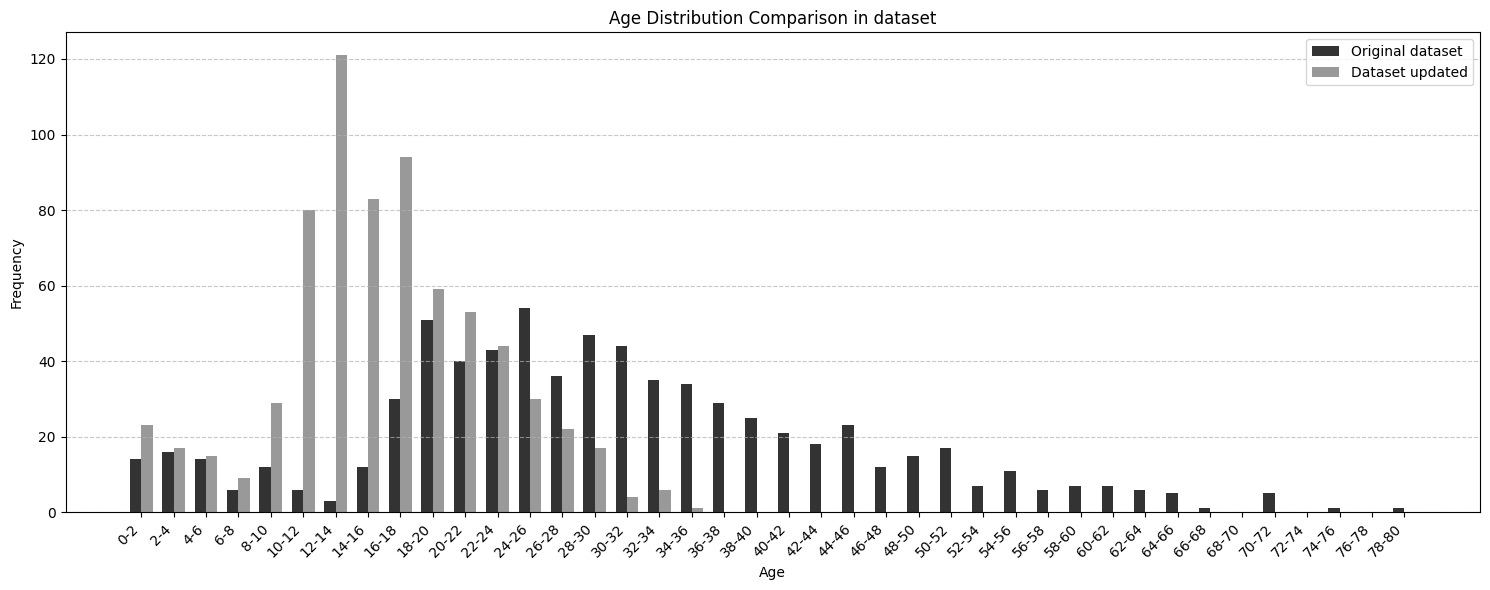

In [31]:
def normalize_age(age):
    # Apply Box-Cox transformation
    age_transformed, lambda_param = stats.boxcox(age)
    # Create a new series with the transformed values
    age_normalized = pd.Series(age_transformed, index=age.index, name='Age')
    print(f"Box-Cox transformation applied with lambda = {lambda_param:.4f}")
    return age_normalized
age_normalized = normalize_age(distrib)
compare_dist(age_normalized)

In [ ]:
shapiro(age_normalized)

Shapiro-Wilk test results:
Statistic: 0.986654
p-value: 0.000004
The Age distribution is likely not normal (reject H0)


# Data inconcistency and errors

## Vertical (columns) issues

In [ ]:
import pandas as pd

# Sample data with inconsistencies
data = {
    'Name': [' John ', 'DOE', 'Alice', ' bob '],
    'Date_of_Birth': ['12/05/1990', '12-05-1990', '1990.05.12', '1990/12/05'],
    'Height(cm)': [180, 5.9, 170, 5.7],  # Heights in both cm and feet
    'Category': ['Yes', 'Y', 'No', 'N'],
    'ref_id': [1, 1, 2, 3],
}

refdata = { 'ref_id': [1, 2, 3],
           'Reference': ['Ref1', 'Ref2', 'Ref3']}

df = pd.DataFrame(data)
df_ref = pd.DataFrame(refdata)

print("Original Data:")
df

Original Data:


,Name,Date_of_Birth,Height(cm),Category,ref_id
0,John,12/05/1990,180.0,Yes,1
1,DOE,12-05-1990,5.9,Y,1
2,Alice,1990.05.12,170.0,No,2
3,bob,1990/12/05,5.7,N,3


In [ ]:
# Standardizing text: trimming and converting to lowercase
df['std_Name'] = df['Name'].str.strip().str.lower()

# Standardizing date formats
def parse_date(date_str): # Custom date parser function
    date_formats = ['%d/%m/%Y', '%m-%d-%Y', '%Y.%m.%d', '%Y/%m/%d']
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT
df['std_Date_of_Birth'] = df['Date_of_Birth'].apply(parse_date)

# Convert heights in feet to cm (assuming values < 100 are in feet)
df['std_Height(cm)'] = df['Height(cm)'].apply(lambda x: x * 30.48 if x < 100 else x)

# Standardizing categorical values
df['std_Category'] = df['Category'].replace({'Y': 'Yes', 'N': 'No'})

# Stadanrdize by using a reference table

df = pd.merge(df, df_ref, on='ref_id', how='left')
df

,Name,Date_of_Birth,Height(cm),Category,ref_id,std_Name,std_Date_of_Birth,std_Height(cm),std_Category,Reference
0,John,12/05/1990,180.0,Yes,1,john,1990-05-12,180.000,Yes,Ref1
1,DOE,12-05-1990,5.9,Y,1,doe,1990-12-05,179.832,Yes,Ref1
2,Alice,1990.05.12,170.0,No,2,alice,1990-05-12,170.000,No,Ref2
3,bob,1990/12/05,5.7,N,3,bob,1990-12-05,173.736,No,Ref3


## Horizontal (row) issues (duplicates)

In [ ]:
import pandas as pd

# Sample data with duplicates
data = {
    'Name': ['John doe', 'John doe', 'Alice Johnson', 'Alice jonson', 'Bob Smith', 'Bob Smith'],
    'Email': ['john@example.com', 'john@example.com', 'alice@domain.com', 'alice@domain2.com', 'bob@website.com', 'bob@website.com'],
    'Date_of_Birth': ['1990-01-01', '1990-01-01', '1985-05-12', '1985-05-12', '1970-08-22', '1970-08-22'],
}

df = pd.DataFrame(data)
print("Original Data:")
df

Original Data:


,Name,Email,Date_of_Birth
0,John doe,john@example.com,1990-01-01
1,John doe,john@example.com,1990-01-01
2,Alice Johnson,alice@domain.com,1985-05-12
3,Alice jonson,alice@domain2.com,1985-05-12
4,Bob Smith,bob@website.com,1970-08-22
5,Bob Smith,bob@website.com,1970-08-22


In [ ]:
# Exact matching: remove exact duplicate rows
df_exact = df.drop_duplicates()
print(df_exact)

            Name              Email Date_of_Birth
0       John doe   john@example.com    1990-01-01
2  Alice Johnson   alice@domain.com    1985-05-12
3   Alice jonson  alice@domain2.com    1985-05-12
4      Bob Smith    bob@website.com    1970-08-22


In [ ]:
# Partial matching: remove duplicates based on the 'Email' column
df_partial = df.drop_duplicates(subset=['Email'])
print("\nAfter Partial Matching Deduplication (Based on Email):")
print(df_partial)


After Partial Matching Deduplication (Based on Email):
            Name              Email Date_of_Birth
0       John doe   john@example.com    1990-01-01
2  Alice Johnson   alice@domain.com    1985-05-12
3   Alice jonson  alice@domain2.com    1985-05-12
4      Bob Smith    bob@website.com    1970-08-22


In [ ]:
!pip install fuzzywuzzy[speedup]

In [ ]:
from fuzzywuzzy import fuzz

# Define a function for fuzzy matching rows
def fuzzy_deduplication(df, threshold=90):
    duplicates = []
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            if fuzz.ratio(df.iloc[i]['Name'].lower(), df.iloc[j]['Name'].lower()) > threshold:
                duplicates.append((i, j))
    return duplicates

# Detect duplicates based on fuzzy matching of the 'Name' column
fuzzy_duplicates = fuzzy_deduplication(df)
print("\nFuzzy Matched Duplicates (Name):")
print(fuzzy_duplicates)

# Drop duplicates (this can be adjusted as per need)
df_fuzzy = df.drop([dup[1] for dup in fuzzy_duplicates])
print("\nAfter Fuzzy Matching Deduplication:")
print(df_fuzzy)


Fuzzy Matched Duplicates (Name):
[(0, 1), (2, 3), (4, 5)]

After Fuzzy Matching Deduplication:
            Name             Email Date_of_Birth
0       John doe  john@example.com    1990-01-01
2  Alice Johnson  alice@domain.com    1985-05-12
4      Bob Smith   bob@website.com    1970-08-22
